# Comparación de Modelos Supervisados con Validación Cruzada

 Problema económico: riesgo de crédito (Give Me Some Credit, Kaggle). 
 
 Métrica principal: ROC AUC. Particiones: 70/15/15 estratificadas.

## Contexto de negocio y decisiones de diseño
- Contexto: predecir **morosidad seria en 2 años** para apoyar políticas de crédito.
- Decisiones: usar variables numéricas, ROC AUC por desbalance, estratificación y pipelines para evitar fugas.
- Éxito: mayor AUC en CV con baja desviación y coherencia en prueba.

## Guía de lectura
- Carga y diagnóstico
- EDA e interpretación
- Partición + Pipeline
- Modelos + Validación Cruzada
- Selección y prueba
- Interpretaciones automáticas y resumen

In [11]:
# Importaciones y configuración
import warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
warnings.filterwarnings('ignore'); sns.set(style='whitegrid'); plt.rcParams['figure.figsize']=(8,5)
SEED=42; DATA_PATH=Path('data'); CSV_FILE=DATA_PATH/'cs-training.csv'
assert CSV_FILE.exists(), f'No se encontró {CSV_FILE}'

## Dataset y objetivo
Qué: historial de clientes para predecir **morosidad seria en 2 años** (`SeriousDlqin2yrs`).
Por qué: caso clásico financiero, variables todas numéricas (>5 predictores).
Cómo interpretar: la etiqueta es desbalanceada; usaremos ROC AUC y estratificación.

In [12]:
df=pd.read_csv(CSV_FILE)
if 'Unnamed: 0' in df.columns: df=df.drop(columns=['Unnamed: 0'])
target='SeriousDlqin2yrs'; features=[c for c in df.columns if c!=target]
display(df.shape)
display(df.head(3))
miss=df.isna().sum()
display(pd.DataFrame({'faltantes':miss[miss>0], '%':(miss[miss>0]/len(df)*100).round(2)}))

(150000, 11)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0


,faltantes,%
MonthlyIncome,29731,19.82
NumberOfDependents,3924,2.62


## EDA: distribución e implicaciones
- Distribución del objetivo: dimensiona el desbalance y guía la métrica.
- Histogramas: detectan asimetrías y outliers; motivan estandarización.
Interpretación: en desbalance, accuracy engaña; ROC AUC y PR son preferibles.

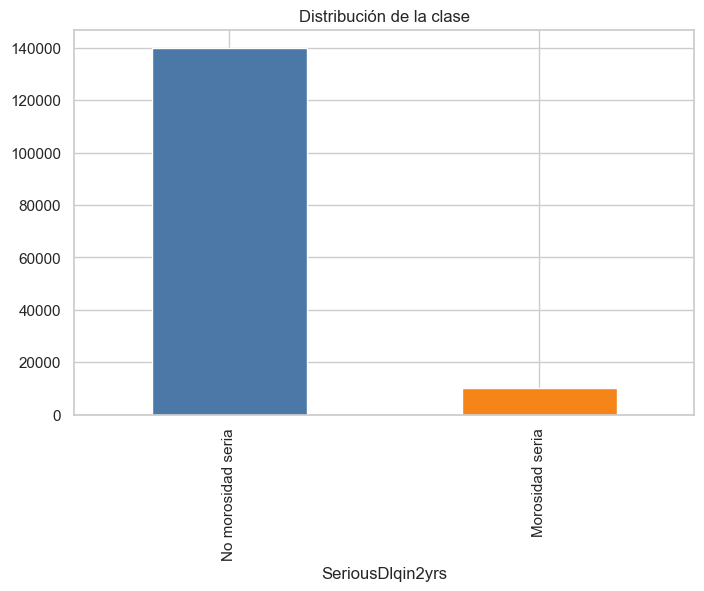

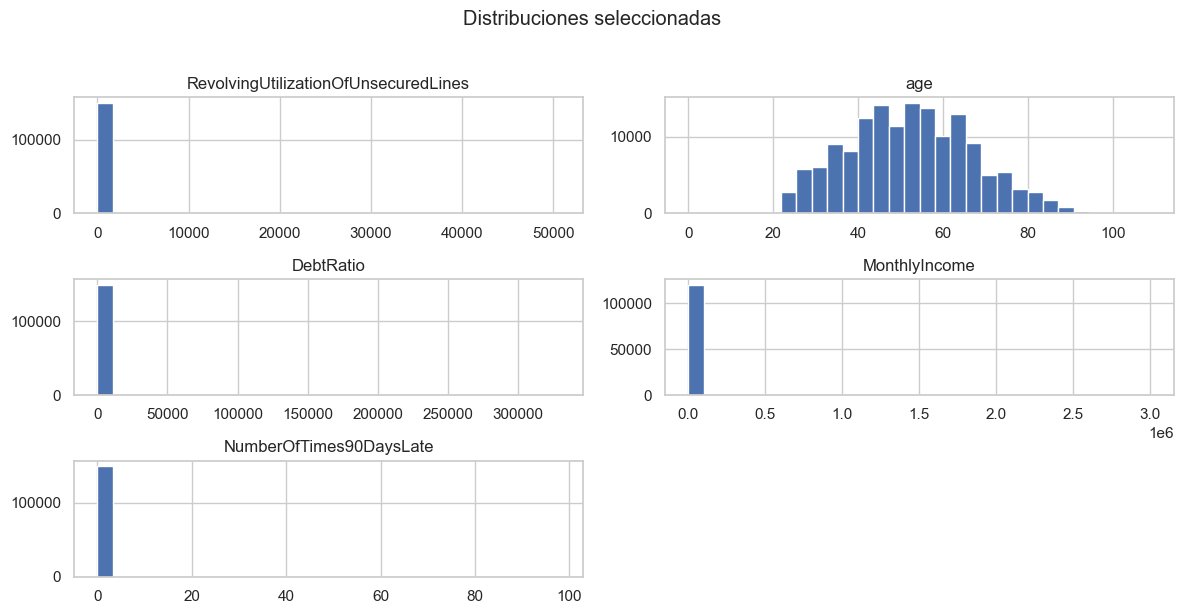

In [13]:
df[target].value_counts().sort_index().plot(kind='bar',color=['#4C78A8','#F58518']);
plt.xticks([0,1],["No morosidad seria","Morosidad seria"]); plt.title('Distribución de la clase'); plt.show()
df[['RevolvingUtilizationOfUnsecuredLines','age','DebtRatio','MonthlyIncome','NumberOfTimes90DaysLate']].hist(bins=30,figsize=(12,6)); plt.suptitle('Distribuciones seleccionadas',y=1.02); plt.tight_layout(); plt.show()

## Partición y pipeline
- Partición 70/15/15 estratificada: conserva proporciones y separa un test independiente.
- Pipeline: imputación (mediana) + StandardScaler para las numéricas.
Beneficio: evita fugas (fit con train) y asegura comparación justa.

In [14]:
X=df[features].copy(); y=df[target].astype(int).copy()
X_train,X_tmp,y_train,y_tmp=train_test_split(X,y,test_size=0.30,random_state=SEED,stratify=y)
X_val,X_test,y_val,y_test=train_test_split(X_tmp,y_tmp,test_size=0.50,random_state=SEED,stratify=y_tmp)
print({'train':len(X_train),'val':len(X_val),'test':len(X_test)})
num_feats=features
preprocess=ColumnTransformer([('num',Pipeline([('imp',SimpleImputer(strategy='median')),('sc',StandardScaler())]),num_feats)])
def make_pipe(model):
    return Pipeline([('prep',preprocess),('model',model)])
models={'LogisticRegression':LogisticRegression(max_iter=1000),'KNeighborsClassifier':KNeighborsClassifier(),'DecisionTreeClassifier':DecisionTreeClassifier(random_state=SEED)}

{'train': 105000, 'val': 22500, 'test': 22500}


## ¿Qué aporta cada modelo?
- LogisticRegression: frontera lineal con probabilidades interpretables.
- KNeighbors: proximidad en espacio estandarizado; capta no linealidades locales.
- DecisionTree: reglas de decisión e interacciones; riesgo de sobreajuste si es profundo.

## Entrenamiento base y Validación Cruzada (K=5)
Qué: medimos AUC en train y val; aplicamos StratifiedKFold sobre train.
Cómo interpretar: `cv_mean_auc` ≈ rendimiento esperado; `cv_std_auc` ≈ estabilidad. Grandes brechas train→val indican sobreajuste.

In [15]:
import numpy as np, pandas as pd
def eval_model(name, est):
    est.fit(X_train,y_train)
    tr=roc_auc_score(y_train, est.predict_proba(X_train)[:,1])
    va=roc_auc_score(y_val, est.predict_proba(X_val)[:,1])
    cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=SEED)
    cvs=cross_val_score(est,X_train,y_train,cv=cv,scoring='roc_auc')
    return {'model':name,'train_auc':tr,'val_auc':va,'cv_mean_auc':float(np.mean(cvs)),'cv_std_auc':float(np.std(cvs,ddof=1)),'cv_scores':cvs}
results=[eval_model(n,make_pipe(m)) for n,m in models.items()]
res=pd.DataFrame(results).sort_values('cv_mean_auc',ascending=False); res[['model','train_auc','val_auc','cv_mean_auc','cv_std_auc']]

,model,train_auc,val_auc,cv_mean_auc,cv_std_auc
0,LogisticRegression,0.694453,0.698939,0.693790,0.008064
1,KNeighborsClassifier,0.948996,0.686719,0.684828,0.003834
2,DecisionTreeClassifier,0.999999,0.609737,0.609639,0.005385


## Selección, reentrenamiento y prueba
Qué: elegimos el mejor por CV, reentrenamos con train+val y evaluamos en test.
Cómo interpretar: el AUC de prueba debería ser similar al `cv_mean_auc` del modelo elegido.

Mejor modelo por CV: LogisticRegression
ROC AUC prueba: 0.7156


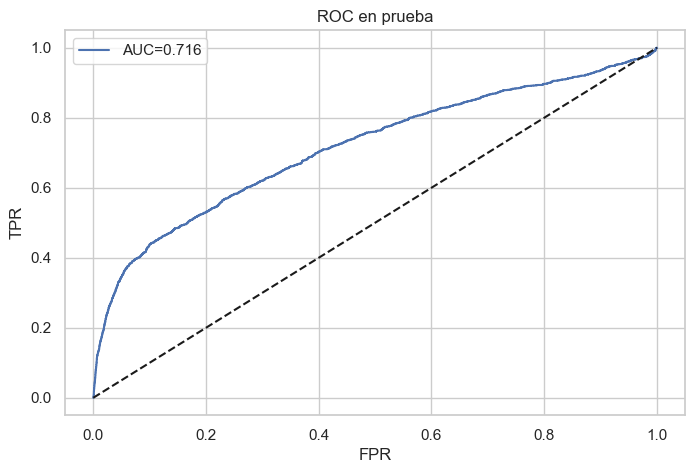

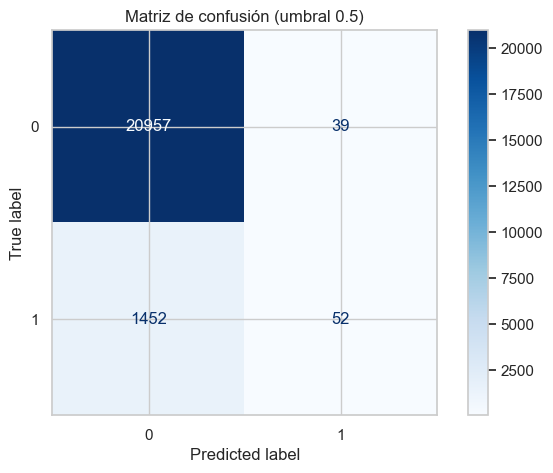

In [16]:
best=res.iloc[0]['model']; print('Mejor modelo por CV:',best)
best_est=make_pipe(models[best])
X_trv=pd.concat([X_train,X_val]); y_trv=pd.concat([y_train,y_val])
best_est.fit(X_trv,y_trv)
proba=best_est.predict_proba(X_test)[:,1]; auc=roc_auc_score(y_test,proba); print('ROC AUC prueba:',round(auc,4))
fpr,tpr,thr=roc_curve(y_test,proba); plt.plot(fpr,tpr,label=f'AUC={auc:.3f}'); plt.plot([0,1],[0,1],'k--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC en prueba'); plt.legend(); plt.show()
ConfusionMatrixDisplay.from_estimator(best_est,X_test,y_test,cmap='Blues'); plt.title('Matriz de confusión (umbral 0.5)'); plt.show()

## Interpretación automática según los datos
Generamos textos con los números reales del dataset y de los modelos para facilitar el informe final.

In [17]:
# 1) Desbalance y faltantes
pos_rate=y.mean(); print(f'Proporción positiva (morosidad): {pos_rate:.2%}')
if pos_rate<0.1: print('Desbalance severo: usar estratificación y métricas como ROC AUC/PR.')
elif pos_rate<0.3: print('Desbalance moderado: preferir ROC AUC y evaluar umbrales.')
else: print('Clases casi balanceadas.')
na = miss[miss>0].sort_values(ascending=False)
if len(na):
    print('Columnas con faltantes y tratamiento: imputación por mediana dentro del pipeline.')
    display(pd.DataFrame({'faltantes':na, '%':(na/len(df)*100).round(2)}))
else:
    print('No se detectaron faltantes relevantes.')

# 2) Correlaciones con el objetivo (lineales)
corr = df[features+[target]].corr(numeric_only=True)[target].drop(target).sort_values(ascending=False)
print('Top correlaciones positivas:'); display(corr.head(5))
print('Top correlaciones negativas:'); display(corr.tail(5))
print('Interpretación: positivos → mayor riesgo; negativos → menor riesgo. Magnitudes pequeñas no descartan relaciones no lineales.')


Proporción positiva (morosidad): 6.68%
Desbalance severo: usar estratificación y métricas como ROC AUC/PR.
Columnas con faltantes y tratamiento: imputación por mediana dentro del pipeline.


,faltantes,%
MonthlyIncome,29731,19.82
NumberOfDependents,3924,2.62


Top correlaciones positivas:


NumberOfTime30-59DaysPastDueNotWorse    0.125587
NumberOfTimes90DaysLate                 0.117175
NumberOfTime60-89DaysPastDueNotWorse    0.102261
NumberOfDependents                      0.046048
RevolvingUtilizationOfUnsecuredLines   -0.001802
Name: SeriousDlqin2yrs, dtype: float64

Top correlaciones negativas:


NumberRealEstateLoansOrLines      -0.007038
DebtRatio                         -0.007602
MonthlyIncome                     -0.019746
NumberOfOpenCreditLinesAndLoans   -0.029669
age                               -0.115386
Name: SeriousDlqin2yrs, dtype: float64

Interpretación: positivos → mayor riesgo; negativos → menor riesgo. Magnitudes pequeñas no descartan relaciones no lineales.


In [18]:
# 3) Lectura de resultados de modelos
best_row = res.iloc[0]; gap = best_row['train_auc']-best_row['val_auc']
print(f"Mejor modelo: {best_row['model']} | AUC train={best_row['train_auc']:.3f}, val={best_row['val_auc']:.3f}, CV={best_row['cv_mean_auc']:.3f}±{best_row['cv_std_auc']:.3f}")
if gap>0.05: print('Sobreajuste (brecha train-val > 0.05).')
else: print('Brecha train-val razonable.')
cv_mean = float(res[res['model']==best]['cv_mean_auc'].values[0])
diff = auc - cv_mean; print(f'Diferencia AUC (test - CV): {diff:+.3f}')
if abs(diff)<=0.02: print('Consistencia alta entre CV y prueba.')
elif abs(diff)<=0.05: print('Consistencia moderada.')
else: print('Diferencia notable; considerar más datos o revisar pipeline.')


Mejor modelo: LogisticRegression | AUC train=0.694, val=0.699, CV=0.694±0.008
Brecha train-val razonable.
Diferencia AUC (test - CV): +0.022
Consistencia moderada.


## Análisis de variables (coeficientes/importancias)
Propósito: identificar qué variables empujan la predicción. Los coeficientes de LR están en escala estandarizada: positivos aumentan la probabilidad de morosidad.

In [19]:
logit = make_pipe(LogisticRegression(max_iter=2000))
logit.fit(X_trv, y_trv)
coef = pd.Series(logit.named_steps['model'].coef_[0], index=num_feats).sort_values(key=np.abs, ascending=False)
display(coef.head(10))
tree = make_pipe(DecisionTreeClassifier(random_state=SEED))
tree.fit(X_trv, y_trv)
imp = pd.Series(tree.named_steps['model'].feature_importances_, index=num_feats).sort_values(ascending=False)
display(imp.head(10))
print('Interpretación: alta utilización de crédito y atrasos previos suelen asociarse a mayor riesgo; mayor edad/ingresos tienden a reducirlo (según signo y contexto).')


NumberOfTime60-89DaysPastDueNotWorse   -3.758367
NumberOfTime30-59DaysPastDueNotWorse    2.022546
NumberOfTimes90DaysLate                 1.891994
MonthlyIncome                          -0.423682
age                                    -0.415212
NumberOfDependents                      0.103311
NumberRealEstateLoansOrLines            0.067541
DebtRatio                              -0.062304
NumberOfOpenCreditLinesAndLoans        -0.039429
RevolvingUtilizationOfUnsecuredLines   -0.004071
dtype: float64

DebtRatio                               0.190068
RevolvingUtilizationOfUnsecuredLines    0.189110
MonthlyIncome                           0.152655
NumberOfTimes90DaysLate                 0.130345
age                                     0.122765
NumberOfOpenCreditLinesAndLoans         0.085992
NumberOfDependents                      0.037378
NumberOfTime30-59DaysPastDueNotWorse    0.032340
NumberOfTime60-89DaysPastDueNotWorse    0.030303
NumberRealEstateLoansOrLines            0.029045
dtype: float64

Interpretación: alta utilización de crédito y atrasos previos suelen asociarse a mayor riesgo; mayor edad/ingresos tienden a reducirlo (según signo y contexto).


## Informe en Markdown autogenerado
La siguiente celda crea un bloque Markdown con un resumen para pegar en el informe/README.

In [20]:
from IPython.display import Markdown, display
cv_mean = float(res[res['model']==best]['cv_mean_auc'].values[0])
summary_md = f'''
### Resumen de hallazgos
- Desbalance: proporción positiva = {pos_rate:.2%}. Estratificación + ROC AUC.
- Faltantes: {int(na.sum()) if len(na) else 0} valores en {len(na)} columnas (imputación mediana).
- Señal lineal destacada: {', '.join(list(corr.head(3).index))} (positivas) y {', '.join(list(corr.tail(3).index))} (negativas).
- Mejor modelo: **{best}** con CV AUC = {cv_mean:.3f} (± {float(res[res['model']==best]['cv_std_auc'].values[0]):.3f}).
- Prueba: AUC = {auc:.3f}; diferencia test−CV = {auc-cv_mean:+.3f} (consistencia {'alta' if abs(auc-cv_mean)<=0.02 else 'moderada' if abs(auc-cv_mean)<=0.05 else 'baja'}).
- Implicación: alta utilización y atrasos incrementan riesgo; edad/ingreso suelen mitigarlo.
'''
display(Markdown(summary_md))



### Resumen de hallazgos
- Desbalance: proporción positiva = 6.68%. Estratificación + ROC AUC.
- Faltantes: 33655 valores en 2 columnas (imputación mediana).
- Señal lineal destacada: NumberOfTime30-59DaysPastDueNotWorse, NumberOfTimes90DaysLate, NumberOfTime60-89DaysPastDueNotWorse (positivas) y MonthlyIncome, NumberOfOpenCreditLinesAndLoans, age (negativas).
- Mejor modelo: **LogisticRegression** con CV AUC = 0.694 (± 0.008).
- Prueba: AUC = 0.716; diferencia test−CV = +0.022 (consistencia moderada).
- Implicación: alta utilización y atrasos incrementan riesgo; edad/ingreso suelen mitigarlo.


## Conclusión y próximos pasos
- Reportar AUC de prueba junto con CV (media y desviación).
- Ajustar umbral según costos (precision‑recall).
- Probar búsqueda de hiperparámetros y técnicas para desbalance (class_weight/SMOTE).
- Documentar implicaciones de negocio: políticas más prudentes ante alta utilización y atrasos.